# Road Signs Bounding Box Prediction using PyTorch

<b>Problem Statement:</b> Predict bounding box around a Road sign in a given image and also predict the type of road sign.

<b>Dataset:</b> https://www.kaggle.com/andrewmvd/road-sign-detection 

(title= Road Signs Dataset ,<br>
url= https://makeml.app/datasets/road-signs,<br>
journal= Make ML)<br>


In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#!unzip road_signs.zip

## Loading the data

In [4]:
images_path = Path('./road_signs/images')
anno_path = Path('./road_signs/annotations')

In [5]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [6]:
df_train = generate_train_df(anno_path)

In [7]:
#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [8]:
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_signs/images/road685.png,300,400,0,84,190,168,274
1,road_signs/images/road834.png,300,400,0,121,144,156,179
2,road_signs/images/road496.png,300,400,0,47,165,72,201
3,road_signs/images/road327.png,300,400,0,92,173,153,234
4,road_signs/images/road135.png,400,247,2,218,75,363,164


## Resizing images and bounding boxes

In [9]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [10]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [11]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [12]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./road_signs/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

### Sample Image

In [13]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(400, 300, 3)


In [14]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([154.,  48., 202.,  96.], dtype=float32)

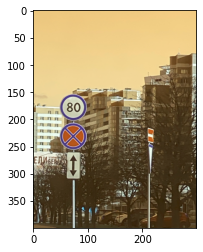

In [15]:
plt.imshow(im)

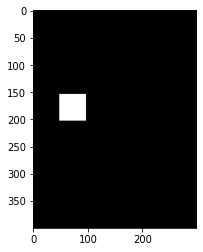

In [16]:
plt.imshow(Y, cmap='gray')

## Data augmentation

Functions in this section borrowed and modified from https://www.usfca.edu/data-institute/certificates/fundamentals-deep-learning 

In [17]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [18]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [19]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

### Sample Image

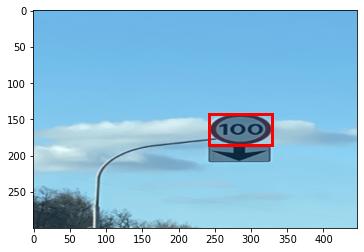

In [20]:
#original
im = cv2.imread(str(df_train.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

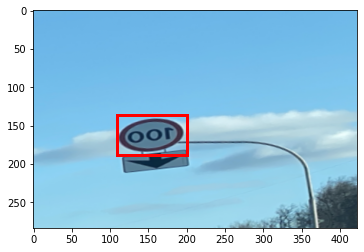

In [21]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]),df_train.values[68][9],True )
show_corner_bb(im, bb)

## Train-valid split

In [22]:
df_train = df_train.reset_index()

In [23]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## Dataset

In [25]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [26]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [27]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [28]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## Model

In [29]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

## Training

In [30]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [31]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [32]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [33]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [34]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 2.476 val_loss 51187.074 val_acc 0.119
train_loss 1.661 val_loss 998.014 val_acc 0.091
train_loss 1.657 val_loss 54.162 val_acc 0.261
train_loss 1.478 val_loss 40.076 val_acc 0.432
train_loss 1.228 val_loss 1.634 val_acc 0.688
train_loss 1.066 val_loss 1.338 val_acc 0.631
train_loss 0.938 val_loss 0.970 val_acc 0.761
train_loss 0.852 val_loss 1.103 val_acc 0.699
train_loss 0.867 val_loss 0.845 val_acc 0.773
train_loss 0.811 val_loss 0.913 val_acc 0.739
train_loss 0.803 val_loss 0.812 val_acc 0.761
train_loss 0.766 val_loss 0.847 val_acc 0.773
train_loss 0.822 val_loss 0.941 val_acc 0.739
train_loss 0.801 val_loss 2.106 val_acc 0.767


0.8008461760386251

In [42]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.765 val_loss 0.817 val_acc 0.790
train_loss 0.721 val_loss 0.783 val_acc 0.790
train_loss 0.729 val_loss 0.775 val_acc 0.790
train_loss 0.728 val_loss 0.773 val_acc 0.801
train_loss 0.726 val_loss 0.798 val_acc 0.795
train_loss 0.689 val_loss 0.771 val_acc 0.807
train_loss 0.687 val_loss 0.773 val_acc 0.795
train_loss 0.699 val_loss 0.765 val_acc 0.795
train_loss 0.675 val_loss 0.759 val_acc 0.801
train_loss 0.666 val_loss 0.745 val_acc 0.795


0.6656981398817816

### Making predictions

In [43]:
# choose random image from validation set
X_val

,new_path,new_bb
710,road_signs/images_resized/road287.png,"[74.0, 218.0, 109.0, 287.0]"
734,road_signs/images_resized/road429.png,"[163.0, 144.0, 191.0, 201.0]"
244,road_signs/images_resized/road813.png,"[129.0, 145.0, 147.0, 185.0]"
231,road_signs/images_resized/road710.png,"[100.0, 197.0, 123.0, 244.0]"
291,road_signs/images_resized/road609.png,"[166.0, 84.0, 194.0, 137.0]"
...,...,...
500,road_signs/images_resized/road789.png,"[126.0, 168.0, 166.0, 247.0]"
215,road_signs/images_resized/road720.png,"[145.0, 147.0, 166.0, 189.0]"
350,road_signs/images_resized/road280.png,"[126.0, 135.0, 159.0, 201.0]"
81,road_signs/images_resized/road337.png,"[148.0, 163.0, 233.0, 331.0]"


In [50]:
# resizing test image
im = read_image('./road_signs/images_resized/road789.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./road_signs/road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [51]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./road_signs/road_signs_test/road789.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [52]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [53]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 4.0389, -0.7852, -1.1573, -0.6184]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[120.0455, 176.9376, 157.2672, 247.1257]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [54]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(values=tensor([4.0389], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([0], device='cuda:0'))

 Class predicted = speedlimit

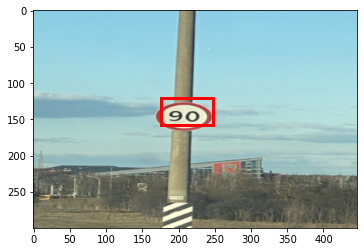

In [55]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [ ]:
import jovian
jovian.commit()

[jovian] Saving notebook..


<IPython.core.display.Javascript object>